In [1]:
import os
import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm, trange
import shutil
import SimpleITK as sitk
import pandas as pd
from scipy.ndimage import zoom as imresize

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (15, 12)

def plot_tubetk(imgs, case, plot_path):
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows, ncols)

    k = 0
    for i in np.arange(nrows):
        for j in np.arange(ncols):
            ax[i][j].imshow(imgs[k])
            ax[i][j].axis('off')
            k += 1

    fig.tight_layout(pad=0, h_pad=0, w_pad=0)
    fpath_plot = '{}/{}.png'.format(plot_path, case)
    plt.savefig(fpath_plot)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [8]:
files = sorted([f for f in glob('/home/srivathsa/projects/studies/gad/mra_synth/preprocess/data/*.npy')])

for fpath in tqdm(files, total=len(files)):
    data = np.load(fpath)
    if np.isnan(data.max()):
        print(fpath.split('/')[-1].replace('.npy', ''))

(1024, 1024, 92)


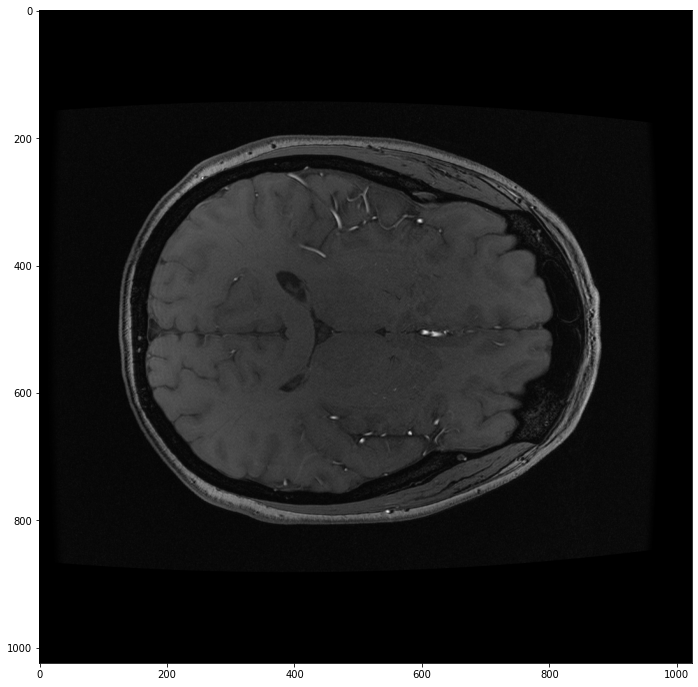

In [13]:
data = nib.load(
    '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/coreg/IXI035-IOP-0873/IXI035-IOP-0873-MRA.nii.gz'
).get_fdata()

plt.imshow(data[..., 46])

print(data.shape)

(256, 256, 136)


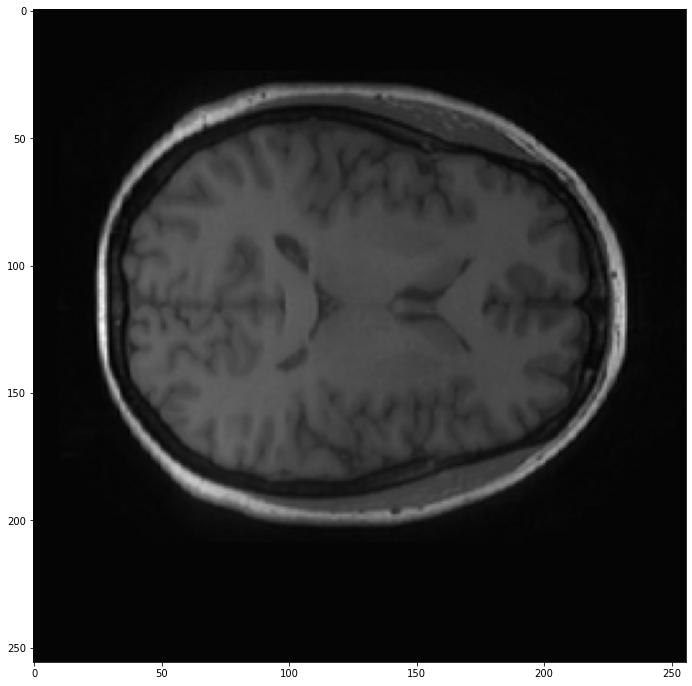

In [6]:
data = nib.load(
    '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered/'\
    'IXI035-IOP-0873/IXI035-IOP-0873-T1.nii.gz'
).get_fdata()
print(data.shape)
plt.imshow(data[..., 73])

### Organize MRA ###

In [ ]:
mra_bpath = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA'
ixi_base = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_dataset'

mra_cases = [f.split('/')[-1].replace('-MRA.nii.gz', '') for f in glob('{}/*.nii.gz'.format(mra_bpath))]
ixi_cases = [f.split('/')[-1] for f in glob('{}/*'.format(ixi_base))]

match_cases = [c for c in ixi_cases if c in mra_cases]

for cnum in tqdm(match_cases, total=len(match_cases)):
    fpath = os.path.join(mra_bpath, '{}-MRA.nii.gz'.format(cnum))
    dpath = os.path.join(ixi_base, cnum, '{}-MRA.nii.gz'.format(cnum))
    shutil.move(fpath, dpath)

### Visualize MRA ###

In [ ]:
base_path = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered'
cnum = 'IXI002-Guys-0828'
cons = ['T1', 'T2', 'MRA']

t1 = nib.load('{}/{}/{}-T1.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
# t1 = t1 / t1.mean()
t2 = nib.load('{}/{}/{}-T2.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
# t2 = t2 / t2.mean()
pd = nib.load('{}/{}/{}-PD.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
# pd = pd / pd.mean()
mra = nib.load('{}/{}/{}-MRA.nii.gz'.format(base_path, cnum, cnum)).get_fdata()
# mra = mra / mra.mean()
print(t1.shape, t2.shape, pd.shape, mra.shape)

In [ ]:
# plt.imshow(np.hstack([t1[..., 65], t2[..., 65], pd[..., 65], mra[..., 65]]))
fig, ax = plt.subplots(2, 2)
sl = 54
ax[0][0].imshow(t1[..., sl])
ax[0][0].axis('off')
ax[0][1].imshow(t2[..., sl])
ax[0][1].axis('off')
ax[1][0].imshow(pd[..., sl])
ax[1][0].axis('off')
ax[1][1].imshow(mra[..., sl])
ax[1][1].axis('off')
fig.tight_layout(pad=0, h_pad=0, w_pad=0)

### Visualize TubeTK dataset

In [ ]:
from medpy.io import load as load_mha

t1, hdr = load_mha('/mnt/datasets/srivathsa/tubetk_mra/raw/TubeTK001/TubeTK001_T1Flash.mha')

t1_stk = hdr.get_sitkimage()
t1_vol = sitk.GetArrayFromImage(t1_stk)

plt.imshow(t1_vol[..., 85])

# t2, _ = load_mha('/mnt/datasets/srivathsa/tubetk_mra/Normal-041/T2/Normal041-T2.mha')
# mra, _ = load_mha('/mnt/datasets/srivathsa/tubetk_mra/Normal-041/MRA/Normal041-MRA.mha')

# print(t1.shape, t2.shape, mra.shape)

In [ ]:
base_path = '/mnt/datasets/srivathsa/tubetk_mra/raw'
cases = sorted([c.split('/')[-1] for c in glob('{}/Normal*'.format(base_path))])

mha_files = sorted([
    f for f in glob('{}/**/*.mha'.format(base_path), recursive=True)
    if 'DTI' not in f
])

con_dicts = []

for fpath_mha in mha_files:
    fname = fpath_mha.split('/')[-1].replace('.mha', '')
    cnum, con = fname.split('_')
    if 'TubeTK' not in cnum:
        continue
    
    crow = [r for r in con_dicts if r['Case'] == cnum]
    if len(crow) > 0:
        crow[0][con] += 1
    else:
        con_row = {
            'Case': cnum,
            'T1Flash': 0,
            'T1MPRage': 0,
            'T2': 0,
            'MRA': 0
        }
        con_row[con] += 1
        con_dicts.append(con_row)

In [ ]:
df_cons = pd.DataFrame(con_dicts)
df_cons['Total'] = df_cons[df_cons.columns[1:]].sum(axis=1)

In [ ]:
df_cons.query('Total >= 3 & T1MPRage == 1')

In [ ]:
plt.imshow(t1[..., 54])

In [ ]:
plt.imshow(t2[..., 80])

In [ ]:
plt.imshow(mra[..., 64])

In [ ]:
def execute_cmd(cmd, verbose=True):
    os.system(cmd)
    if verbose:
        print(cmd)

In [ ]:
# organize each contrast into the same folder
dataset_dir = '/mnt/raid/jiang/projects/SubtleGAN/data/IXI/IXI_dataset'
os.makedirs(dataset_dir, exist_ok=True)
t2_files = glob.glob("/mnt/raid/jiang/projects/SubtleGAN/data/IXI/IXI-T2/*.nii.gz")
for t2_file in t2_files:
    case_name = t2_file.split("/")[-1].split(".")[0][:-3]
    t1_files = glob.glob(f"/mnt/raid/jiang/projects/SubtleGAN/data/IXI/IXI-T1/{case_name}*")
    pd_files = glob.glob(f"/mnt/raid/jiang/projects/SubtleGAN/data/IXI/IXI-PD/{case_name}*")
    # if all contrasts exist
    if len(t1_files) == 1 and len(pd_files) == 1:
        case_dir = os.path.join(dataset_dir, case_name)
        os.makedirs(case_dir, exist_ok=True)
        execute_cmd(f"ln -s {t2_file} {case_dir}/")
        execute_cmd(f"ln -s {t1_files[0]} {case_dir}/")
        execute_cmd(f"ln -s {pd_files[0]} {case_dir}/")
    

In [ ]:
# # split dataset 
# import random
# import pickle
# images = glob.glob("../../data/IXI/IXI_dataset/IXI*")
# random.shuffle(images)
# train_ratio = 0.9
# val_ratio = 0.05
# test_ratio = 0.05
# cases = [case.split("/")[-1] for case in images]
# n_cases = len(cases)
# n_train = int(n_cases*train_ratio)
# n_val = int(n_cases*val_ratio)
# n_test = int(n_cases*test_ratio)

# train_cases = [case.split("/")[-1] for case in images[:n_train]]
# val_cases = [case.split("/")[-1] for case in images[n_train:n_train+n_val]]
# test_cases = [case.split("/")[-1] for case in images[n_train+n_val:]]

# data_split = {'train_cases': train_cases, 'val_cases': val_cases, "test_cases": test_cases}
# with open('data_split_IXI.pickle', 'wb') as handle:
#     pickle.dump(data_split, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
# split dataset into train/test/val
with open('data_split_IXI.pickle', 'rb') as handle:
    data_split = pickle.load(handle)
train_dir = '/home/jiang/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered_splitted/train/'
test_dir = '/home/jiang/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered_splitted/test/'
val_dir = '/home/jiang/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered_splitted/val/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
data_dir = "/home/jiang/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered/"
for case in data_split['train_cases']:
    case_dir = os.path.join(data_dir, case)
    cmd = f"ln -s {case_dir} {train_dir}"
    #print(cmd)
    os.system(cmd)
    
for case in data_split['val_cases']:
    case_dir = os.path.join(data_dir, case)
    cmd = f"ln -s {case_dir} {val_dir}"
    #print(cmd)
    os.system(cmd)
    
for case in data_split['test_cases']:
    case_dir = os.path.join(data_dir, case)
    cmd = f"ln -s {case_dir} {test_dir}"
    #print(cmd)
    os.system(cmd)


In [4]:
# preprocessing: divide each case by the mean
def preprocess_data(data, norm=True, resize=256):
    if norm:
        data = data/data.mean()
    if data.shape[0] != resize:
        zfactor = resize / data.shape[0]
        data = imresize(data, (zfactor, zfactor, 1.0))
    #data = data[38:198, 32:224, :]
    #data = np.pad(data, ((8,8), (8,8), (0,0)), 'constant', constant_values=0)
    return data

In [10]:
data_types = ['train', 'test', 'val']
data_types = ['train']
skip_tb = 0
for data_type in data_types:
    data_dir = f'/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/split/{data_type}'
    save_dir = f'/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/slices/{data_type}'
    cases = sorted([c.split('/')[-1] for c in glob(f"{data_dir}/IXI*") if 'IOP' in c])
    proc_cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(save_dir))])
#     cases = [c for c in cases if c not in proc_cases]
    cases = ['IXI218-HH-1815']
    
    for case in tqdm(cases, total=len(cases)):
        case_dir = os.path.join(data_dir, case)
        save_case_dir = os.path.join(save_dir, case)
        os.makedirs(save_case_dir, exist_ok=True)
        t1 = preprocess_data(nib.load(glob(f"{case_dir}/*T1.nii.gz")[0]).get_fdata())
        t2 = preprocess_data(nib.load(glob(f"{case_dir}/*T2.nii.gz")[0]).get_fdata())
        pd = preprocess_data(nib.load(glob(f"{case_dir}/*PD.nii.gz")[0]).get_fdata())
        mra_file = glob(f"{case_dir}/*MRA.nii.gz")
        if len(mra_file) == 0:
            print('Skipping {}. No MRA found'.format(case))
            continue
        mra = preprocess_data(nib.load(mra_file[0]).get_fdata())
        n_slices = t2.shape[-1]
        for idx in range(skip_tb, n_slices-skip_tb):
            slice_i = np.stack([t1[:, :, idx], t2[:, :, idx], pd[:, :, idx], mra[:, :, idx]], axis=0)
            fn = os.path.join(save_case_dir, f"{idx:03d}.npy")
            np.save(fn, slice_i)

<ipython-input-10-af9cd7e9ed19>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for case in tqdm(cases, total=len(cases)):


  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
bpath = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/slices/val'
npy_files = sorted([fp for fp in glob('{}/**/*.npy'.format(bpath), recursive=True)])

for fpath in tqdm(npy_files, total=len(npy_files)):
    d = np.load(fpath)
    if d.shape[0] != 4:
        print(d.shape, fpath)

<ipython-input-19-11efe1a3b47f>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fpath in tqdm(npy_files, total=len(npy_files)):


  0%|          | 0/2684 [00:00<?, ?it/s]

In [ ]:
bpath = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_dataset'
case = 'IXI113-Guys-0776'
cons = ['T1', 'T2', 'PD', 'MRA']

vol = np.array([nib.load('{}/{}/{}-{}.nii.gz'.format(bpath, case, case, con)).get_fdata() for con in cons])
print(vol.shape)


In [ ]:
print(vol[0].shape, vol[1].shape, vol[2].shape, vol[3].shape)

In [16]:
data_types = ['train', 'test', 'val']
plot_base = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/slices/plots'
sl_dir = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/slices'
for split in data_types:
    plot_dir = '{}/{}'.format(plot_base, split)
    cases = sorted([c.split('/')[-1] for c in glob('{}/{}/*'.format(sl_dir, split))])
    proc_cases = sorted([
        c.split('/')[-1].replace('.png', '') 
        for c in glob('{}/*.png'.format(os.path.join(plot_base, split)))
    ])
    cases = [c for c in cases if c not in proc_cases]
    
    for cnum in tqdm(cases, total=len(cases)):
        case_dir = os.path.join(sl_dir, split, cnum)
        all_slices = sorted([s for s in glob('{}/*.npy'.format(case_dir))])
        
        fpath_ctr = all_slices[len(all_slices) // 2]
        data = np.load(fpath_ctr)
        plot_tubetk([*data], cnum, os.path.join(plot_base, split))


<ipython-input-16-2fb7fd67a35e>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cnum in tqdm(cases, total=len(cases)):


  0%|          | 0/334 [00:00<?, ?it/s]

<ipython-input-1-401cafc22c60>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows, ncols)


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

In [ ]:
bpath = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/coreg/IXI002-Guys-0828'

cons = ['T1', 'T2', 'PD', 'MRA']
data = np.array([nib.load('{}/IXI002-Guys-0828-{}.nii.gz'.format(bpath, con)).get_fdata() for con in cons])
print(data.shape)

In [ ]:
plt.imshow(np.hstack([*data[..., 0]]))

In [ ]:
data_dst = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/split/test'
case_src = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_dataset_coregistered_splitted/test'
cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(case_src))])
data_src = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/coreg'

for cnum in tqdm(cases, total=len(cases)):
    dpath_src = os.path.join(data_src, cnum)
    dpath_dst = os.path.join(data_dst, cnum)
    os.symlink(dpath_src, dpath_dst)

In [14]:
bpath = '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/slices/train'
cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(bpath))])
for cnum in cases:
    npy_files = [f for f in glob('{}/{}/*.npy'.format(bpath, cnum))]
    if len(npy_files) == 0:
        print(cnum)

IXI213-HH-1642
IXI225-Guys-0832
IXI233-IOP-0875


In [21]:
from dataset_ixi import IXI_dataset

db = IXI_dataset(
    base_dir='/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/slices_mini',
    split='val'
)

In [23]:
val_item = db.__getitem__(0)
print(val_item.shape)

(4, 256, 256)
